# Orbitrap-sort

Version 1.0 (31/1/23)

A script to process cleaned Orbitrap scan data and flag outling injections

### Input: 
The path to a series of 'additional_output' files from Thermo R script (v3) which contain cleaned Orbitrap data for every scan in a run

### Outputs: 
1. For each injection, a 'injection_sorted' file  which contain the for each scan, the sample name, timestamp, TIC, ion count and ratio for each isotopologue measured
2. One summary '_summary' file containing, for each injection: mean isotopologue ratios, plateau start/stop times (min), scan count, mean TIC (/s), mean ion injection time (ms), and median scan duration (ms)

### Import packages and specify input parameters

In [38]:
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning
import os
import numpy as np
import matplotlib.pyplot as plt
sep=''

path = '240208_CdD_202-215_M0/'
outputpath = 'data_sorted/'

datafiles = [string for string in os.listdir(path)  if string.split('_')[0]=='Additional' ] 
if len(datafiles)==1:
    inputpath = datafiles[0]
    print('Found data file at ' + path+inputpath)
else:
    inputpath = datafiles[0]
    print('Found multiple data files. Using ' + path+inputpath)
    


Found data file at 240208_CdD_202-215_M0/Additional_Output_2024-02-08.csv


### Read and sort additional_output files
Saves '_sorted.csv' files for each injection and one summary '_summary.csv' file in the outputpath folder

In [10]:
# create folder for sorted output
def create_folder(directory, folder_name):
    # Combine the directory path and folder name
    folder_path = os.path.join(directory, folder_name)
    
    # Check if the folder doesn't already exist
    if not os.path.exists(folder_path):
        try:
            # Create the folder
            os.makedirs(folder_path)
            print(f"Folder '{folder_name}' created successfully at '{directory}'.")
        except OSError as e:
            print(f"Error creating folder: {e}")
    else:
        print(f"Folder '{folder_name}' already exists at '{directory}'.")

create_folder(path, outputpath)


# Read the CSV file into a DataFrame
data = pd.read_csv(sep.join([path,inputpath]))

# add zero to filename suffixes
def change_suffix(s):
    parts = s.split('_')
    if len(parts) > 1:
        if len(parts[-1])<2:
            s = sep.join([s[0:-2],'_0',parts[-1]])
    return s

# Sorting by filename suffix
data['filename'] = data['filename'].apply(change_suffix)
data = data.sort_values(by='filename')

# Extract filenames
filenames = data['filename'].unique()

# DataFrame for metadata
summ=pd.DataFrame(columns=['sample_name','filename','start_t_min','stop_t_min','scans','TIC_av','injection_t_ms','scan_dur_ms'],index=range(len(filenames)))

# Loop through files
for i,fn in enumerate(filenames):

    # Take one injection only
    df = data[data['filename'] == fn]
    df = df.sort_values(by='time.min')

# nitrate M0 expt
    if df['compound'].iloc[0]=='NO3-' and df['Basepeak'].iloc[0]=='M0 is base peak':

        experiment = 'NO3_M0'
        # separate isotopologues into their own DataFrame
        M0_df = df[df['isotopolog'] == 'M0'][['sample.name','time.min','tic','ions.incremental']].rename(columns={'ions.incremental':'ions_M0'})
        N15_df = df[df['isotopolog'] == '15N'][['time.min','Ratio']]
        O17_df = df[df['isotopolog'] == '17O'][['time.min','Ratio']]
        O18_df = df[df['isotopolog'] == '18O'][['time.min','Ratio']]
        # merge DataFrames on time column
        ratio_df = pd.merge(M0_df,N15_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_15N'})
        ratio_df = pd.merge(ratio_df,O17_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_17O'})
        ratio_df = pd.merge(ratio_df,O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_18O'})

# nitrate no-M0 expt
    if df['compound'].iloc[0]=='NO3-' and df['Basepeak'].iloc[0]=='15N is base peak':

        experiment = 'NO3_noM0'
        # separate isotopologues into their own DataFrame
        N15_df = df[df['isotopolog'] == '15N'][['sample.name','time.min','tic','ions.incremental']].rename(columns={'ions.incremental':'ions_15N'})
        O17_df = df[df['isotopolog'] == '17O'][['time.min','Ratio']]
        O18_df = df[df['isotopolog'] == '18O'][['time.min','Ratio']]
        N15O18_df = df[df['isotopolog'] == '15N18O'][['time.min','Ratio']]
        O15N17O18_df = df[df['isotopolog'] == '17O18O'][['time.min','Ratio']]
        O18O18_df = df[df['isotopolog'] == '18O18O'][['time.min','Ratio']]
        # merge DataFrames on time column
        ratio_df = pd.merge(N15_df,O17_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_17O'})
        ratio_df = pd.merge(ratio_df,O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_18O'})
        ratio_df = pd.merge(ratio_df,O17_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_17O'})
        ratio_df = pd.merge(ratio_df,N15O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_15N18O'})
        ratio_df = pd.merge(ratio_df,O17O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_17O18O'})
        ratio_df = pd.merge(ratio_df,O18O18_df, on='time.min',how='outer').rename(columns={'Ratio':'Ratio_18O18O'})

    # sort by time.min column, add experiment column
    ratio_df = ratio_df.sort_values(by='time.min')
    ratio_df.insert(1,'experiment',[experiment]*len(ratio_df))
    # save output to .csv
    ratio_df.to_csv(sep.join([path, outputpath, fn, '_sorted_',df['sample.name'].iloc[0],'.csv']))
    
    mean_ratios = ratio_df[ratio_df.columns[[col.startswith('Ratio') for col in ratio_df.columns]]].mean()
    for col,val in mean_ratios.iloc[::-1].items():
        if col in summ.columns:
            summ.at[i,col] = val
        else:
            summ.insert(1,col,[np.nan]*len(summ))
            summ.at[i,col] = val
    
    summ['sample_name'].iloc[i]=df['sample.name'].iloc[0]
    summ['filename'].iloc[i]=''.join([fn, '_sorted_',df['sample.name'].iloc[0],'.csv'])
    summ['scans'].iloc[i]=len(df[df['isotopolog']==df['isotopolog'].iloc[0]])
    summ['start_t_min'].iloc[i]=df['time.min'].min()
    summ['stop_t_min'].iloc[i]=df['time.min'].max()
    summ['TIC_av'].iloc[i]=df['tic'].mean()
    summ['injection_t_ms'].iloc[i]=df['it.ms'].mean()
    summ['scan_dur_ms'].iloc[i]=np.median(np.array(df[df['isotopolog']==df['isotopolog'].iloc[0]]['time.min'].iloc[1:])-np.array(df[df['isotopolog']==df['isotopolog'].iloc[0]]['time.min'].iloc[:-1]))*60000

# export metadata as csv
summ.to_csv(sep.join([path, outputpath,fn.split('_')[0],'_summary.csv']))

print('Saved '+ str(len(filenames)) + ' sorted data files from ' + filenames[0] + ' to ' + filenames[-1] + '.')
print('Saved summary file as ' + sep.join([path, outputpath,fn.split('_')[0],'_summary.csv.']))

Folder 'data_sorted/' already exists at '240208_CdD_202-215_M0/'.
Saved 150 sorted data files from 240206_002 to 240206_151.
Saved summary file as 240208_CdD_202-215_M0/data_sorted/240206_summary.csv.


## Check for mistakes and outlying injections


### Plot average TICs and isotopologue ratios over sequence - check for empty vials and outliers
$TIC < 4\times10^6$    implies ion injection time exceeds scan duration for nitrate experiment

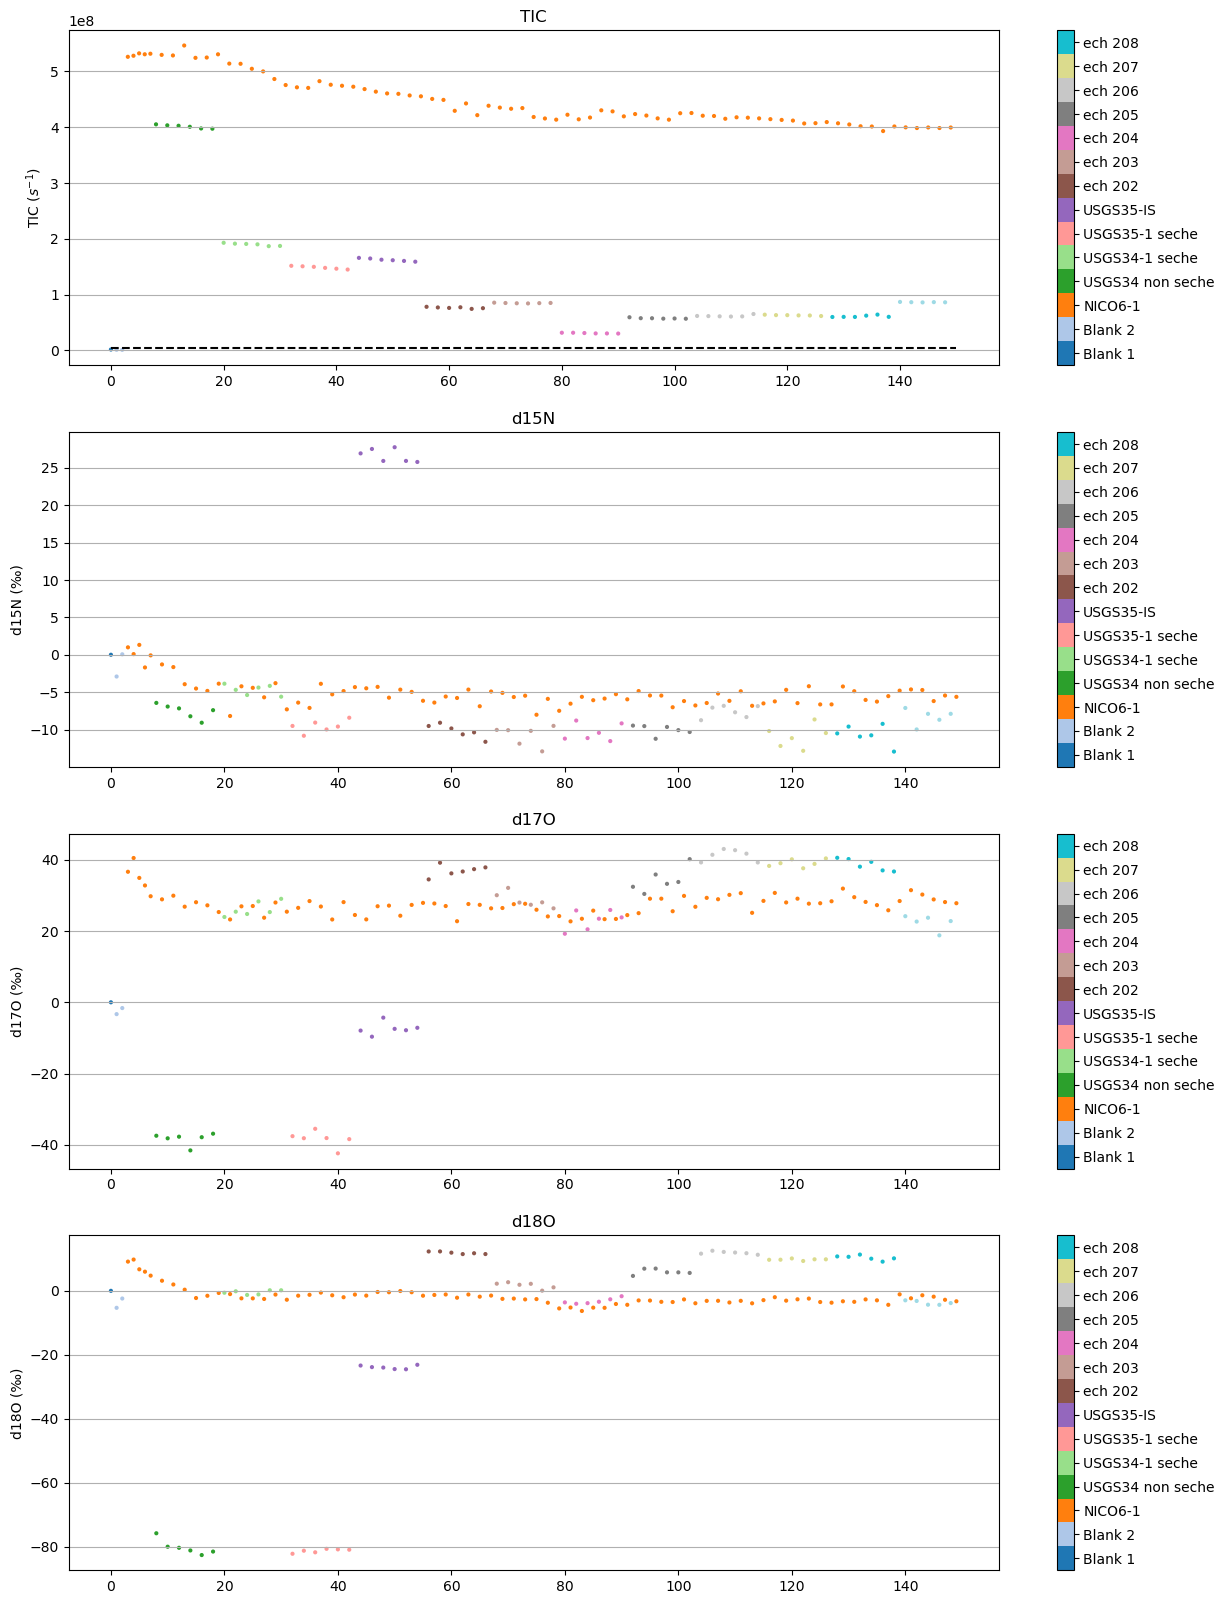

In [22]:
summ = pd.read_csv(os.path.join(path, outputpath, [string for string in os.listdir(os.path.join(path,outputpath)) if string.split('_')[-1]=='summary.csv' ][0]))

filenames = summ['filename']
rcols = ratio_df.columns[[col.startswith('Ratio') for col in ratio_df.columns]]

fig,ax = plt.subplots(1+len(rcols), figsize=[15,5*(1+len(rcols))])

categories = summ['sample_name']

from matplotlib.colors import ListedColormap
tab10_cmap = plt.get_cmap('tab20')
colors = tab10_cmap(np.linspace(0, 1, len(categories.unique())))
discrete_cmap = ListedColormap(colors)

category_mapping = {category: i for i, category in enumerate(categories.unique())}
numeric_categories = np.array([category_mapping[category] for category in categories])

# TIC plot
scatter = ax[0].scatter(summ.index, summ['TIC_av'], c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.')
cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) + 1)) - 0.5)
cbar.set_ticklabels(np.unique(categories))
ax[0].plot([0,len(summ)],[4e6, 4e6], '--',c='k')
# ax.set_yscale('log')
ax[0].grid(True, axis='y')
ax[0].set_ylabel('TIC ($s^{-1}$)')
ax[0].set_title('TIC')

# isotopologue ratio plots
for i,col in enumerate(rcols):
    j=i+1
    scatter = ax[j].scatter(summ.index, (summ[col]/summ.loc[0,col]-1)*1000, c=numeric_categories, cmap=discrete_cmap, lw=0, marker='.')
    cbar = plt.colorbar(scatter, ticks=np.unique(numeric_categories), boundaries=np.arange(len(np.unique(numeric_categories) + 1)) - 0.5)
    cbar.set_ticklabels(np.unique(categories))
    ax[j].grid(True, axis='y')
    ax[j].set_ylabel('d' + col.split('_')[-1] + ' (‰)')
    ax[j].set_title('d' + col.split('_')[-1])

### Plot TIC, $\delta^{15}N$, and $\delta^{18}O$ curves for each sample
Set plots = True to see plots  
Add samples to exclude to nonsamples list

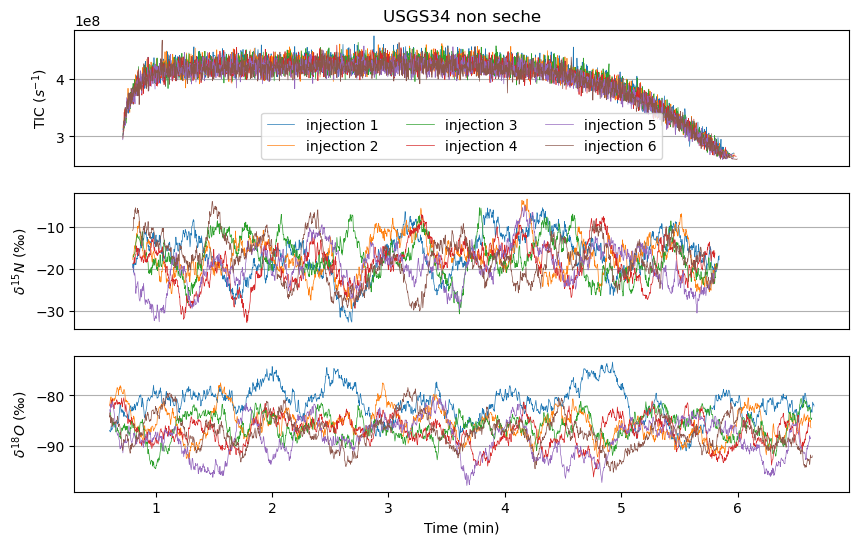

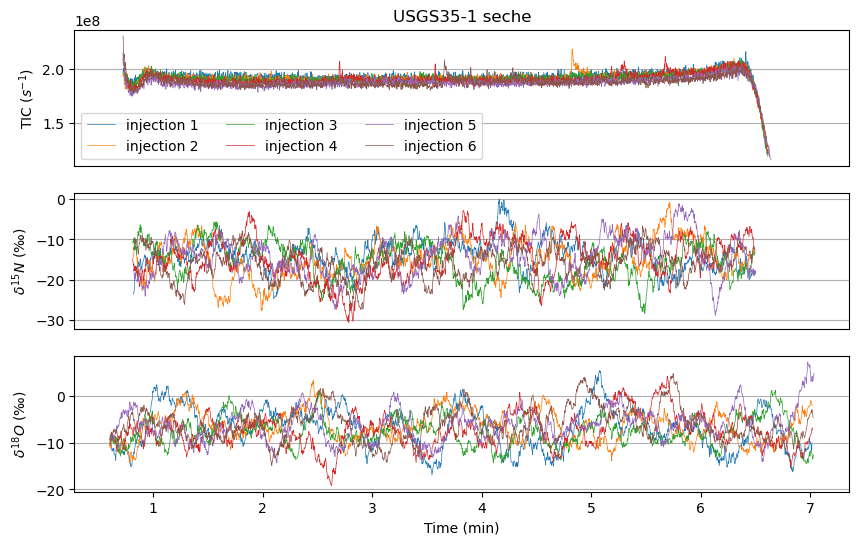

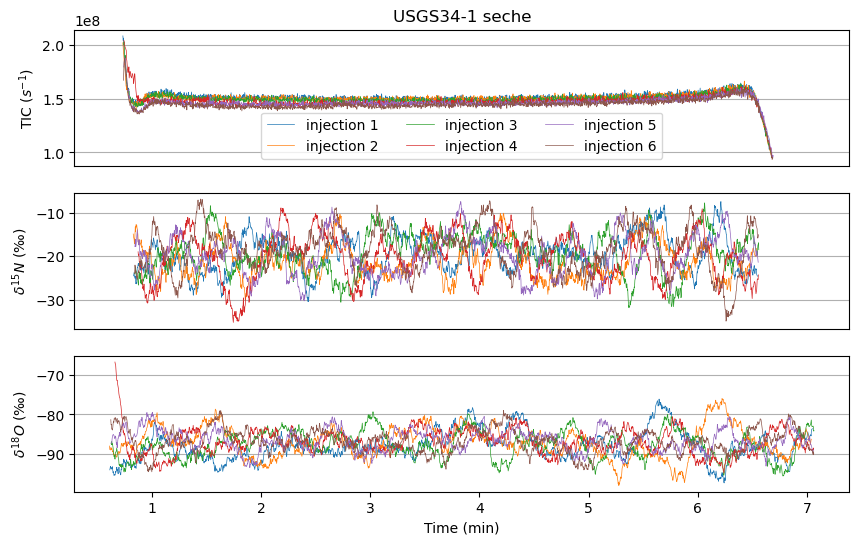

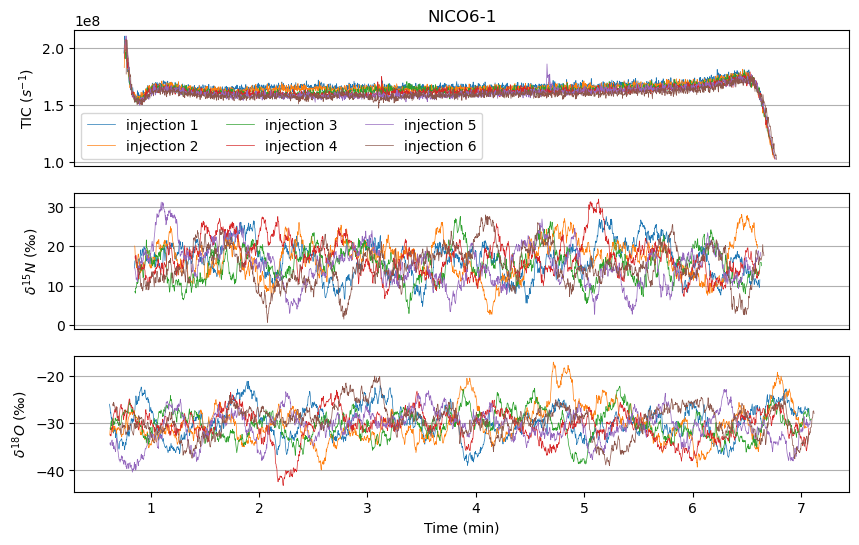

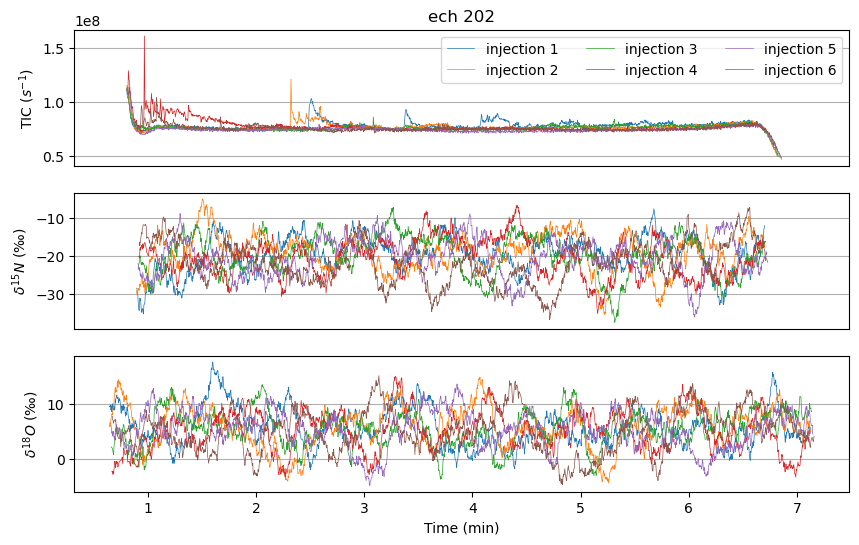

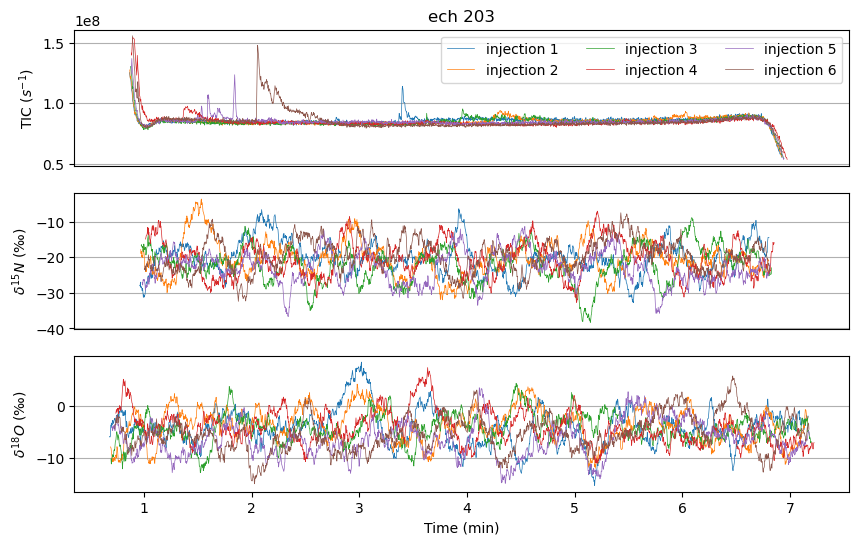

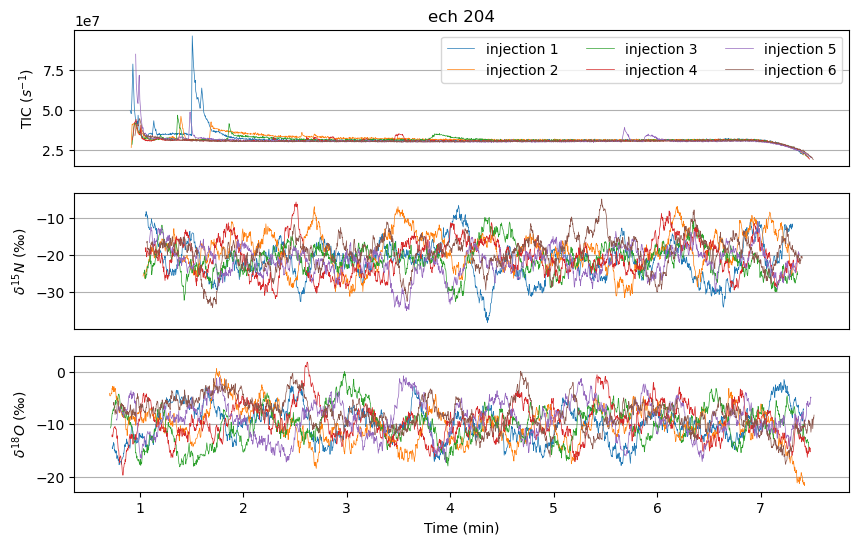

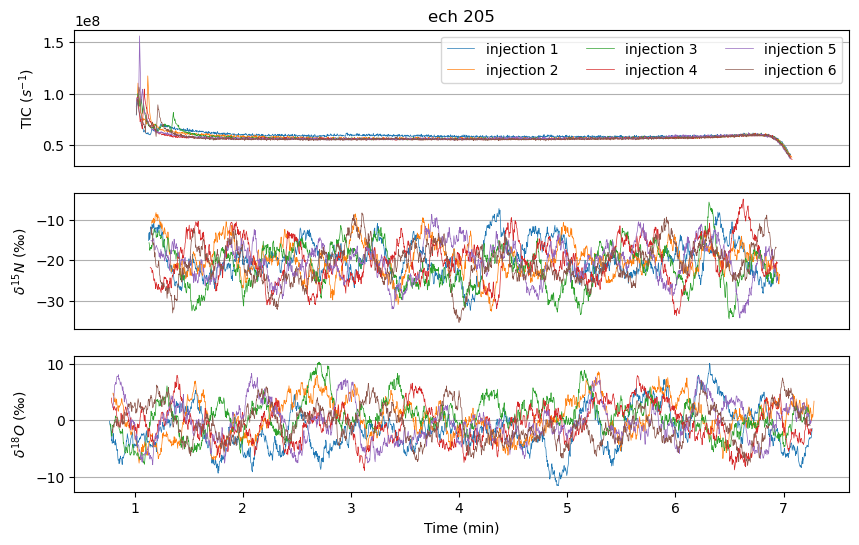

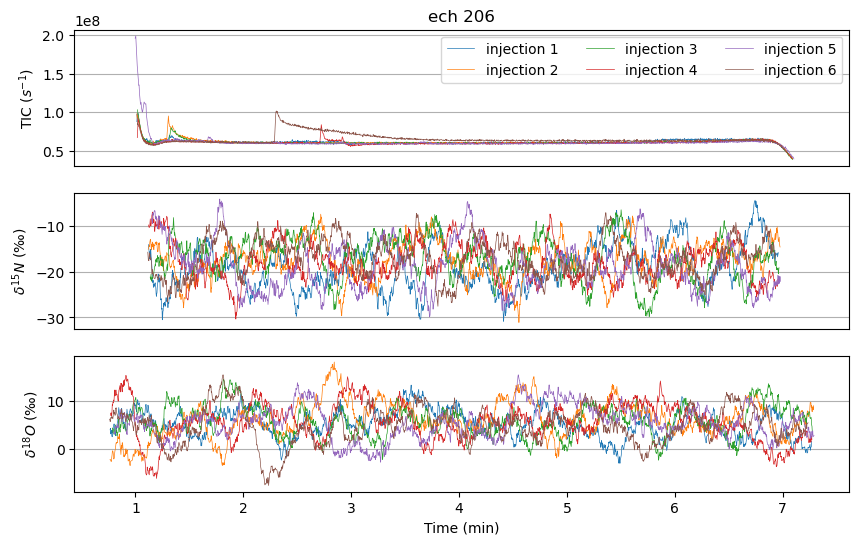

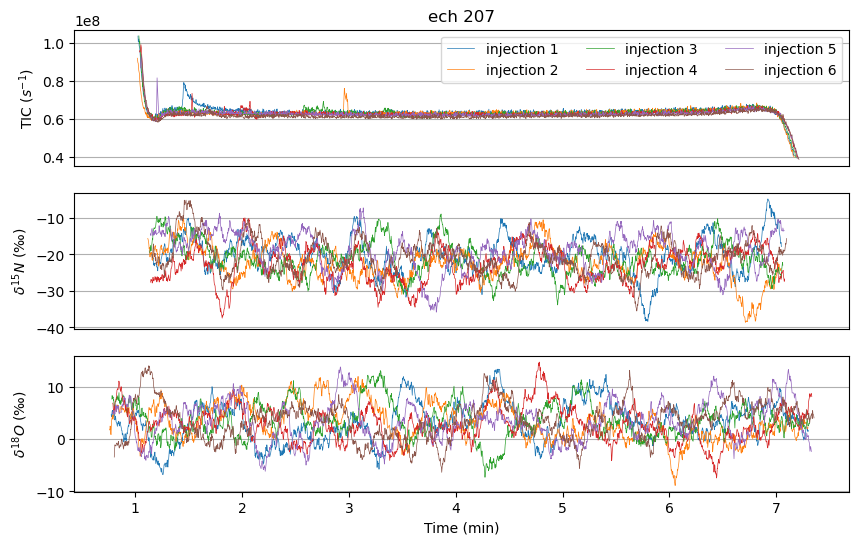

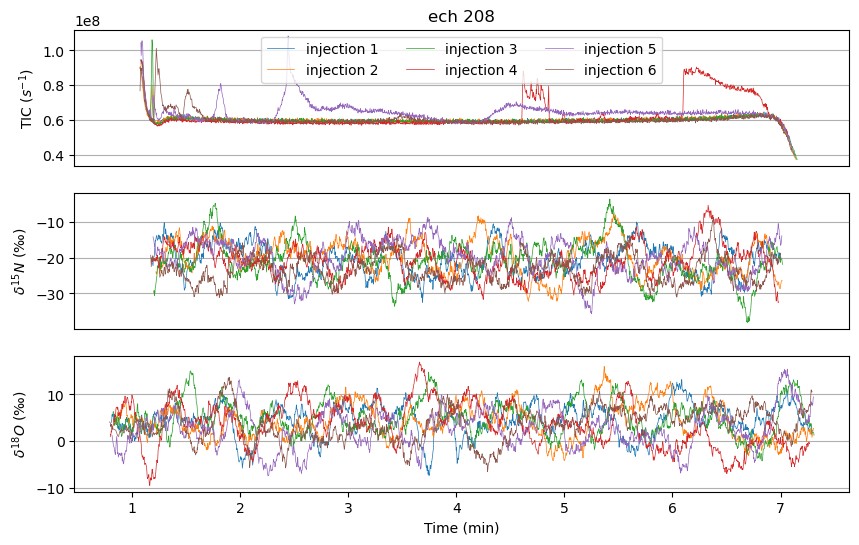

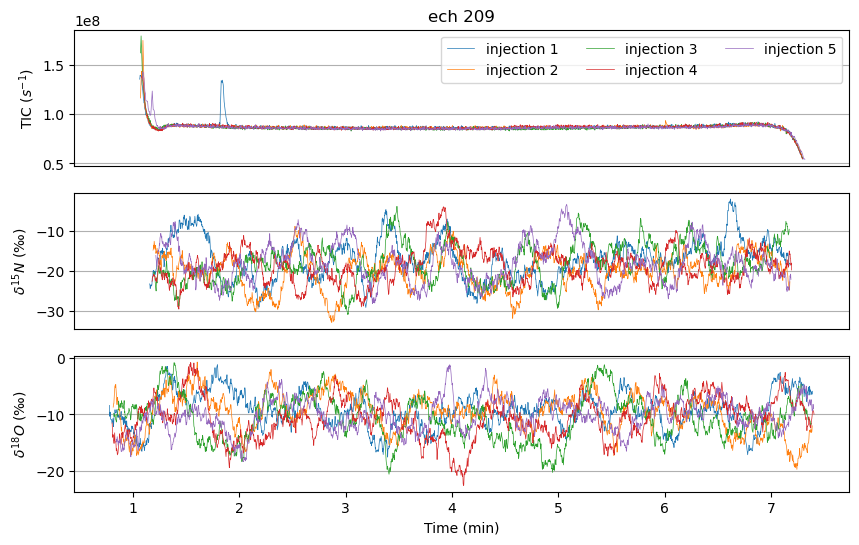

In [37]:
plots = True
nonsamples = ['USGS35-IS','Blank 1','Blank 2']

# load metadata.csv
summ = pd.read_csv(os.path.join(path,outputpath,[s for s in os.listdir(os.path.join(path,outputpath)) if s.endswith('_summary.csv')][0]))

sample_names = np.array([x for x in summ['sample_name'].unique() if x not in nonsamples])

for i, sample in enumerate(sample_names):
    if plots == True: 
        fig,ax = plt.subplots(3, figsize = [10,6])
        samplefilenames = summ[summ['sample_name']==sample]['filename']

        for j, sam in enumerate(samplefilenames):

            data = pd.read_csv(os.path.join(path,outputpath,sam))
            scandur = 0.003
            meandur = 0.2
            window_size = int(meandur / scandur)
            data[['Rolling_15N','Rolling_17O','Rolling_18O']] = data[['Ratio_15N','Ratio_17O','Ratio_18O']].rolling(window=window_size, center=True).mean()

            ax[0].set_title(data['sample.name'].iloc[0])

            ax[0].plot(data['time.min'],data['tic'], label='injection '+str(j+1), lw=0.5)
            ax[0].set_xlim([0, 8])
            ax[0].grid(True, axis='y')
            ax[0].set_ylabel('TIC ($s^{-1}$)')
            ax[0].legend(ncols=3)        
            ax[0].set_xticks([])

            ax[1].plot(data['time.min'],1000*(data['Rolling_15N']/0.0044-1), lw=0.5)
            ax[1].set_xlim(ax[0].get_xlim())
            ax[1].grid(True, axis='y')
            ax[1].set_ylabel('$\delta^{15}N$ (‰)')
            ax[1].set_xticks([])

            ax[2].plot(data['time.min'],1000*(data['Rolling_18O']/0.0086-1), lw=0.5)
            ax[1].set_xlim(ax[0].get_xlim())
            ax[2].grid(True, axis='y')
            ax[2].set_ylabel('$\delta^{18}O$ (‰)')

            ax[-1].set_xlabel('Time (min)')